# Generative Models
***

**MIPT, Autumn 2022, MSc course**


## Assignment 2

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Rostislav Korst*

***


Let's continue our dive into the classical generative models! Today's goal is to implement Conditional GAN for MNIST dataset. Conditional image generation is the task of generating new images conditional on their class. Feel free to rewrite this skeleton or reuse your code from the previous assignment.

Good luck!

## 1. Conditional GAN
*Source: <a href="https://arxiv.org/pdf/1411.1784.pdf" target="_blank">Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014)</a>.*

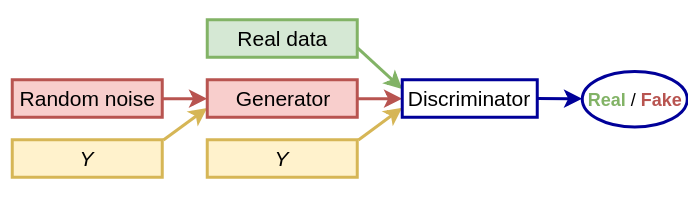

Picture source: https://medium.datadriveninvestor.com/an-introduction-to-conditional-gans-cgans-727d1f5bb011

### Imports

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.display import Image
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image
from torch.autograd import Variable

%matplotlib inline
plt.style.use("ggplot")

### Some parameters

In [ ]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
number_class = 10

if device == "cuda:0":
    !nvidia-smi

sample_dir = "./images_cgan"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

### Load dataset and create dataloader

In [3]:
# Load MNIST dataset
mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

data_loader = torch.utils.data.DataLoader(mnist,
                                          batch_size=batch_size,
                                          shuffle=True,
)

/home/kontsevaya/sberocrs/sber-ocr-2/.sberocr-env2/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Label:  5


(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([-1.        , -0.86771244, -0.7354248 , -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.4551634 ,  0.587451  ,  0.71973854,  0.85202616,
         0.9843137 ], dtype=float32),
 <a list of 100 BarContainer objects>)

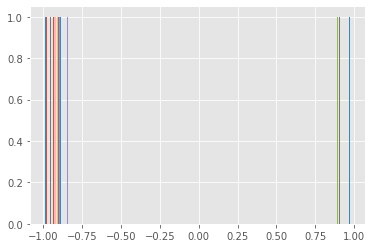

In [4]:
# plot pixels distribution
img, label = mnist[0]
print('Label: ', label)
# Your code here
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [5]:
img.shape, img.min(1, keepdim=True)[0].shape

(torch.Size([1, 28, 28]), torch.Size([1, 1, 28]))

In [5]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    # Your code here
    shape = x.shape
    #print(*shape)
    x = x.view(x.size(0), -1)
    #print(x.shape, x.min(1, keepdim=True)[0].shape)
    x -= x.min(1, keepdim=True)[0]
    #print(x)
    x /= x.max(1, keepdim=True)[0]
    #print(x)
    return x.view(*shape)

Label:  5
Label: 5


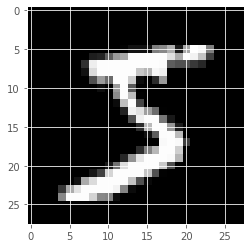

In [6]:
# Let's plot something
img, label = mnist[0]
print("Label: ", label)

img_norm = denorm(img)
#print(img_norm)
plt.imshow(img_norm[0], cmap="gray")
print("Label:", label)

### Define the models

Define the Discriminator network, the Generator network with additional input for condition

In [7]:
number_class = 10

class Generator(nn.Module):
    def __init__(self, n_class, latent_size, image_size, hidden_size): # pass number_class and use nn.Embedding here
        # linear1 - relu - linear2 - relu - linear3 - tanh
        super(Generator, self).__init__()
        
        self.label_embedding = nn.Embedding(n_class, n_class)
        latent_size += n_class
        
        ## set a linear layer with input size is latent_size and output size is hidden_size
        self.linear1 = nn.Linear(latent_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear2 = nn.Linear(hidden_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is image_size
        self.linear3 = nn.Linear(hidden_size, image_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()


    def forward(self, x, label):
        # concat label embedding with random latent vector
        c = self.label_embedding(label)
        x = torch.cat([x, c], 1)
        l1 = self.relu(self.linear1(x))
        l2 = self.relu(self.linear2(l1))
        l3 = self.tanh(self.linear3(l2))
        return l3.to(device)


class Discriminator(nn.Module):
    def __init__(self, n_class, image_size, hidden_size): # pass number_class and use nn.Embedding here
        # linear1 - leaky_relu - linear2 - leaky_relu - linear3 - sigmoid
        super(Discriminator, self).__init__()
        
        self.label_embedding = nn.Embedding(n_class, n_class)
        image_size += n_class
        
        ## set a linear layer with input size is image_size and output size is hidden_size
        self.linear1 = nn.Linear(image_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear2 = nn.Linear(hidden_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is 1
        self.linear3 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, label):
        # concat label embedding with input image
        c = self.label_embedding(label)
        x = torch.cat([x, c], 1)
        l1 = self.relu(self.linear1(x))
        l2 = self.relu(self.linear2(l1))
        l3 = self.sigmoid(self.linear3(l2))
        return l3

Answer the question: why the last layer of generator is $Tanh$ and the last discriminator layer is $Sigmoid$?

Именно такие функции активации используются для того, чтобы привести значения элементов тензора к нужному диапозону: в случае дискриминатора нам нужны значения от 0 до 1 (классы real и fake), а для генератора у нас используются нормализованные значения от -1 до 1, которые как раз и получаются из тангенса

In [8]:
# create new Generator model

G = Generator(number_class, latent_size, image_size, hidden_size).to(device)

# create new Discriminator model

D = Discriminator(number_class, image_size, hidden_size).to(device)

In [9]:
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
#beta1 = 0.5
G_optimizer = torch.optim.Adam(G.parameters(), lr=LR)
D_optimizer = torch.optim.Adam(D.parameters(), lr=LR)

### Discriminator Training

In [10]:
def train_discriminator(images, c):
    # Create the labels which are later used as input for the BCE loss
    real_labels = Variable(torch.ones(batch_size, 1).to(device))
    outputs = D(images, c)
    # Loss for real images
    real_loss = criterion(outputs, real_labels)
    real_score = outputs 

    # Loss for fake images
    z = Variable(torch.randn(batch_size, latent_size).to(device))
    fake_class_labels = torch.randint(0, number_class, (batch_size,)).to(device)
    fake_images = G(z, fake_class_labels)
    
    outputs = D(fake_images.detach(), fake_class_labels)
    fake_score = outputs
    
    fake_labels = Variable(torch.zeros(batch_size, 1).to(device))
    fake_loss = criterion(outputs, fake_labels)

    # Sum losses
    loss = real_loss + fake_loss
    
    # Reset gradients
    G_optimizer.zero_grad()
    D_optimizer.zero_grad()
    
    loss.backward()
    
    D_optimizer.step()
    
    return loss, real_score, fake_score

### Generator Training

In [11]:
def train_generator():
    # Sample random vector
    z = Variable(torch.randn(batch_size, latent_size).to(device))
    fake_class_labels = torch.randint(0, number_class, (batch_size,)).to(device)
    fake_images = G(z, fake_class_labels)
    outputs = D(fake_images, fake_class_labels)
    
    labels = torch.ones(batch_size, 1).to(device)
    loss = criterion(outputs, labels)
    
    G_optimizer.zero_grad()
    D_optimizer.zero_grad()
    
    # Backprop and optimize
    loss.backward()
    
    G_optimizer.step()

    return loss, fake_images

### Start the training proccess

In [12]:
def save_fake_images(index):
    # Sample random vector
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(
        device
    )
    gens_label = torch.randint(0, number_class, (batch_size,)).to(device)
    # Generate images with Generator
    fake_images = G(sample_vectors, gens_label).cpu()
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [13]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, digit) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = Variable(images.reshape(batch_size, -1).to(device))
        #print(images.shape)
        digit = digit.to(device)
        #print(digit.shape)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images, digit)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
#         break
#     break
    # Sample and save images
    save_fake_images(epoch + 1)

Epoch [0/300], Step [200/600], d_loss: 0.1139, g_loss: 3.2240, D(x): 0.97, D(G(z)): 0.08
Epoch [0/300], Step [400/600], d_loss: 0.4884, g_loss: 4.7065, D(x): 0.94, D(G(z)): 0.31
Epoch [0/300], Step [600/600], d_loss: 0.1205, g_loss: 4.1710, D(x): 0.94, D(G(z)): 0.05
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.3962, g_loss: 3.0465, D(x): 0.87, D(G(z)): 0.11
Epoch [1/300], Step [400/600], d_loss: 1.5281, g_loss: 1.7179, D(x): 0.59, D(G(z)): 0.34
Epoch [1/300], Step [600/600], d_loss: 0.5603, g_loss: 3.4535, D(x): 0.84, D(G(z)): 0.21
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.9736, g_loss: 2.8466, D(x): 0.80, D(G(z)): 0.45
Epoch [2/300], Step [400/600], d_loss: 0.4038, g_loss: 2.8492, D(x): 0.85, D(G(z)): 0.14
Epoch [2/300], Step [600/600], d_loss: 0.3138, g_loss: 2.8263, D(x): 0.91, D(G(z)): 0.18
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.5943, g_loss: 3.2330, D(x): 0.81, D(G(z)): 0.18
Epoch [3/300], Step [400/6

Epoch [27/300], Step [600/600], d_loss: 0.6174, g_loss: 2.6130, D(x): 0.77, D(G(z)): 0.12
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.7389, g_loss: 2.6790, D(x): 0.78, D(G(z)): 0.17
Epoch [28/300], Step [400/600], d_loss: 0.3930, g_loss: 3.0057, D(x): 0.88, D(G(z)): 0.16
Epoch [28/300], Step [600/600], d_loss: 0.4951, g_loss: 2.8704, D(x): 0.81, D(G(z)): 0.13
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 1.0141, g_loss: 2.0274, D(x): 0.63, D(G(z)): 0.18
Epoch [29/300], Step [400/600], d_loss: 0.6957, g_loss: 1.8845, D(x): 0.80, D(G(z)): 0.26
Epoch [29/300], Step [600/600], d_loss: 0.6199, g_loss: 2.5471, D(x): 0.76, D(G(z)): 0.16
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.8465, g_loss: 2.0507, D(x): 0.81, D(G(z)): 0.34
Epoch [30/300], Step [400/600], d_loss: 0.4725, g_loss: 2.4074, D(x): 0.83, D(G(z)): 0.18
Epoch [30/300], Step [600/600], d_loss: 0.6449, g_loss: 2.6946, D(x): 0.78, D(G(z)): 0.16
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.8625, g_loss: 2.2247, D(x): 0.65, D(G(z)): 0.15
Epoch [55/300], Step [600/600], d_loss: 0.6511, g_loss: 1.7275, D(x): 0.80, D(G(z)): 0.26
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.5758, g_loss: 2.1614, D(x): 0.84, D(G(z)): 0.26
Epoch [56/300], Step [400/600], d_loss: 0.6683, g_loss: 2.2787, D(x): 0.79, D(G(z)): 0.23
Epoch [56/300], Step [600/600], d_loss: 0.7379, g_loss: 2.0140, D(x): 0.74, D(G(z)): 0.22
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 1.1081, g_loss: 1.7265, D(x): 0.63, D(G(z)): 0.25
Epoch [57/300], Step [400/600], d_loss: 0.7268, g_loss: 2.1352, D(x): 0.78, D(G(z)): 0.25
Epoch [57/300], Step [600/600], d_loss: 1.1173, g_loss: 1.2990, D(x): 0.66, D(G(z)): 0.32
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.5381, g_loss: 2.9522, D(x): 0.78, D(G(z)): 0.14
Epoch [58/300], Step [400/600], d_loss: 0.8646, g_loss: 1.8812, D(x): 0.74, D(G(z)): 0.26
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 1.0375, g_loss: 1.5864, D(x): 0.63, D(G(z)): 0.31
Epoch [83/300], Step [400/600], d_loss: 0.9834, g_loss: 1.2084, D(x): 0.71, D(G(z)): 0.36
Epoch [83/300], Step [600/600], d_loss: 0.9422, g_loss: 1.6358, D(x): 0.66, D(G(z)): 0.30
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.8230, g_loss: 1.6884, D(x): 0.71, D(G(z)): 0.25
Epoch [84/300], Step [400/600], d_loss: 0.9883, g_loss: 1.3372, D(x): 0.68, D(G(z)): 0.35
Epoch [84/300], Step [600/600], d_loss: 1.1352, g_loss: 1.3742, D(x): 0.64, D(G(z)): 0.36
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 1.1096, g_loss: 1.5887, D(x): 0.67, D(G(z)): 0.35
Epoch [85/300], Step [400/600], d_loss: 1.2039, g_loss: 1.5386, D(x): 0.57, D(G(z)): 0.34
Epoch [85/300], Step [600/600], d_loss: 1.1909, g_loss: 1.3818, D(x): 0.59, D(G(z)): 0.35
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.8095, g_loss: 1.6281, D(x): 0.70, D(G(z)): 0.25
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 0.9709, g_loss: 1.4756, D(x): 0.62, D(G(z)): 0.31
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 1.0251, g_loss: 1.5478, D(x): 0.67, D(G(z)): 0.35
Epoch [111/300], Step [400/600], d_loss: 1.0721, g_loss: 1.2633, D(x): 0.66, D(G(z)): 0.36
Epoch [111/300], Step [600/600], d_loss: 1.0296, g_loss: 1.5704, D(x): 0.64, D(G(z)): 0.33
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.9984, g_loss: 1.3705, D(x): 0.66, D(G(z)): 0.35
Epoch [112/300], Step [400/600], d_loss: 0.9704, g_loss: 1.6426, D(x): 0.61, D(G(z)): 0.26
Epoch [112/300], Step [600/600], d_loss: 0.9770, g_loss: 1.4623, D(x): 0.65, D(G(z)): 0.30
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 1.1338, g_loss: 1.2133, D(x): 0.63, D(G(z)): 0.38
Epoch [113/300], Step [400/600], d_loss: 1.1640, g_loss: 1.1627, D(x): 0.62, D(G(z)): 0.39
Epoch [113/300], Step [600/600], d_loss: 0.8635, g_loss: 1.3998, D(x): 0.70, D(G(z)): 0.32
Saving

Epoch [138/300], Step [200/600], d_loss: 1.0653, g_loss: 1.1751, D(x): 0.64, D(G(z)): 0.36
Epoch [138/300], Step [400/600], d_loss: 0.9707, g_loss: 1.1309, D(x): 0.67, D(G(z)): 0.36
Epoch [138/300], Step [600/600], d_loss: 1.1281, g_loss: 1.2024, D(x): 0.65, D(G(z)): 0.40
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 1.4550, g_loss: 1.2081, D(x): 0.57, D(G(z)): 0.45
Epoch [139/300], Step [400/600], d_loss: 1.1160, g_loss: 1.2728, D(x): 0.62, D(G(z)): 0.36
Epoch [139/300], Step [600/600], d_loss: 1.3479, g_loss: 1.2368, D(x): 0.56, D(G(z)): 0.43
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 1.0766, g_loss: 1.0208, D(x): 0.66, D(G(z)): 0.40
Epoch [140/300], Step [400/600], d_loss: 1.0259, g_loss: 1.2164, D(x): 0.62, D(G(z)): 0.32
Epoch [140/300], Step [600/600], d_loss: 0.9857, g_loss: 1.3046, D(x): 0.61, D(G(z)): 0.29
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 1.2666, g_loss: 1.0714, D(x): 0.56, D(G(z)): 0.38
Epoch 

Epoch [165/300], Step [400/600], d_loss: 1.0642, g_loss: 0.9649, D(x): 0.68, D(G(z)): 0.42
Epoch [165/300], Step [600/600], d_loss: 1.2203, g_loss: 1.0559, D(x): 0.63, D(G(z)): 0.43
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 0.9655, g_loss: 1.2994, D(x): 0.64, D(G(z)): 0.35
Epoch [166/300], Step [400/600], d_loss: 1.0068, g_loss: 1.0881, D(x): 0.67, D(G(z)): 0.38
Epoch [166/300], Step [600/600], d_loss: 1.1422, g_loss: 1.1718, D(x): 0.57, D(G(z)): 0.35
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 1.2468, g_loss: 1.2443, D(x): 0.60, D(G(z)): 0.42
Epoch [167/300], Step [400/600], d_loss: 1.0008, g_loss: 1.3657, D(x): 0.67, D(G(z)): 0.36
Epoch [167/300], Step [600/600], d_loss: 1.1343, g_loss: 1.2418, D(x): 0.59, D(G(z)): 0.37
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 1.1089, g_loss: 1.0343, D(x): 0.62, D(G(z)): 0.39
Epoch [168/300], Step [400/600], d_loss: 1.1607, g_loss: 1.0551, D(x): 0.64, D(G(z)): 0.42
Epoch 

Epoch [192/300], Step [600/600], d_loss: 1.1196, g_loss: 1.1274, D(x): 0.62, D(G(z)): 0.39
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 1.2097, g_loss: 1.1576, D(x): 0.59, D(G(z)): 0.39
Epoch [193/300], Step [400/600], d_loss: 1.2616, g_loss: 0.9653, D(x): 0.56, D(G(z)): 0.39
Epoch [193/300], Step [600/600], d_loss: 1.1135, g_loss: 1.1204, D(x): 0.63, D(G(z)): 0.38
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 1.2672, g_loss: 1.1737, D(x): 0.55, D(G(z)): 0.38
Epoch [194/300], Step [400/600], d_loss: 1.2240, g_loss: 1.1058, D(x): 0.57, D(G(z)): 0.40
Epoch [194/300], Step [600/600], d_loss: 1.1112, g_loss: 1.0777, D(x): 0.62, D(G(z)): 0.38
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 1.1272, g_loss: 1.0584, D(x): 0.62, D(G(z)): 0.39
Epoch [195/300], Step [400/600], d_loss: 1.1301, g_loss: 0.9861, D(x): 0.60, D(G(z)): 0.39
Epoch [195/300], Step [600/600], d_loss: 1.0117, g_loss: 1.2410, D(x): 0.66, D(G(z)): 0.36
Saving

Epoch [220/300], Step [200/600], d_loss: 1.0652, g_loss: 1.1460, D(x): 0.61, D(G(z)): 0.35
Epoch [220/300], Step [400/600], d_loss: 1.0520, g_loss: 1.0324, D(x): 0.65, D(G(z)): 0.40
Epoch [220/300], Step [600/600], d_loss: 1.1842, g_loss: 0.9667, D(x): 0.60, D(G(z)): 0.42
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 1.3893, g_loss: 1.0162, D(x): 0.54, D(G(z)): 0.43
Epoch [221/300], Step [400/600], d_loss: 1.1244, g_loss: 1.2154, D(x): 0.66, D(G(z)): 0.42
Epoch [221/300], Step [600/600], d_loss: 1.0556, g_loss: 1.0747, D(x): 0.67, D(G(z)): 0.40
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 1.1410, g_loss: 1.0622, D(x): 0.64, D(G(z)): 0.41
Epoch [222/300], Step [400/600], d_loss: 1.0394, g_loss: 1.2924, D(x): 0.62, D(G(z)): 0.34
Epoch [222/300], Step [600/600], d_loss: 0.9434, g_loss: 1.3050, D(x): 0.67, D(G(z)): 0.34
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 1.1262, g_loss: 1.0020, D(x): 0.60, D(G(z)): 0.38
Epoch 

Epoch [247/300], Step [400/600], d_loss: 1.1286, g_loss: 1.1405, D(x): 0.61, D(G(z)): 0.39
Epoch [247/300], Step [600/600], d_loss: 1.2335, g_loss: 1.0777, D(x): 0.58, D(G(z)): 0.37
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 1.1538, g_loss: 1.1952, D(x): 0.64, D(G(z)): 0.41
Epoch [248/300], Step [400/600], d_loss: 1.0768, g_loss: 1.0869, D(x): 0.63, D(G(z)): 0.38
Epoch [248/300], Step [600/600], d_loss: 1.1521, g_loss: 1.0814, D(x): 0.60, D(G(z)): 0.38
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 0.9457, g_loss: 1.2376, D(x): 0.72, D(G(z)): 0.39
Epoch [249/300], Step [400/600], d_loss: 1.2179, g_loss: 1.1885, D(x): 0.62, D(G(z)): 0.42
Epoch [249/300], Step [600/600], d_loss: 0.8981, g_loss: 1.4203, D(x): 0.65, D(G(z)): 0.31
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.8355, g_loss: 1.4043, D(x): 0.68, D(G(z)): 0.28
Epoch [250/300], Step [400/600], d_loss: 1.0536, g_loss: 1.1293, D(x): 0.62, D(G(z)): 0.37
Epoch 

Epoch [274/300], Step [600/600], d_loss: 1.1052, g_loss: 1.2825, D(x): 0.58, D(G(z)): 0.33
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 1.1134, g_loss: 1.1665, D(x): 0.62, D(G(z)): 0.40
Epoch [275/300], Step [400/600], d_loss: 1.0893, g_loss: 1.2021, D(x): 0.64, D(G(z)): 0.39
Epoch [275/300], Step [600/600], d_loss: 1.2545, g_loss: 1.0416, D(x): 0.59, D(G(z)): 0.41
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 1.0393, g_loss: 1.0645, D(x): 0.62, D(G(z)): 0.33
Epoch [276/300], Step [400/600], d_loss: 0.9670, g_loss: 1.3407, D(x): 0.67, D(G(z)): 0.36
Epoch [276/300], Step [600/600], d_loss: 1.0770, g_loss: 1.1922, D(x): 0.63, D(G(z)): 0.37
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 1.3296, g_loss: 1.0576, D(x): 0.59, D(G(z)): 0.45
Epoch [277/300], Step [400/600], d_loss: 1.3474, g_loss: 0.9711, D(x): 0.62, D(G(z)): 0.49
Epoch [277/300], Step [600/600], d_loss: 0.9891, g_loss: 1.2785, D(x): 0.62, D(G(z)): 0.32
Saving

### Show your conditional generation results for each class independently

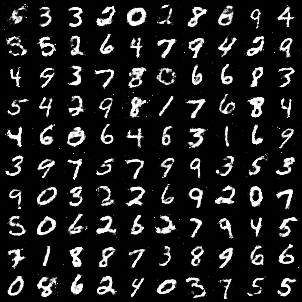

In [15]:
from PIL import Image
Image.open(os.path.join(sample_dir, "fake_images-0300.png"))

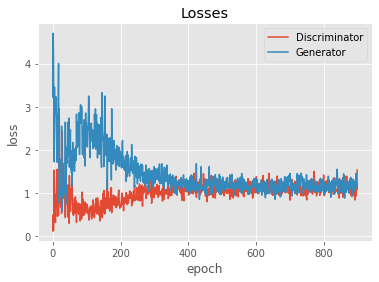

In [16]:
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

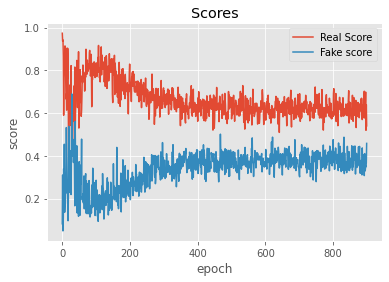

In [17]:
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

8


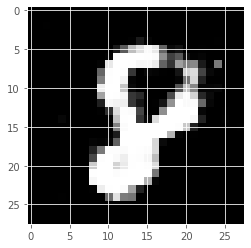

0


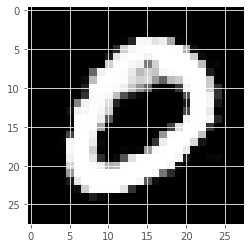

7


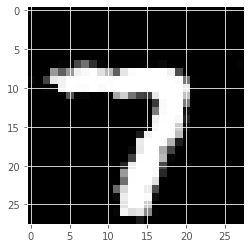

6


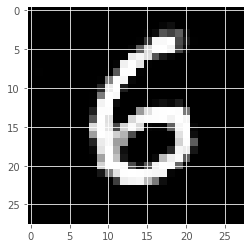

0


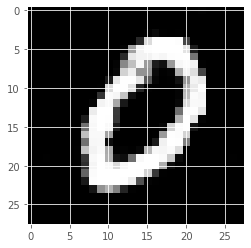

In [20]:
z = torch.randn(batch_size, latent_size).to(device)
fake_class_labels = torch.randint(0, number_class, (batch_size,)).to(device)
generated_data = G(z, fake_class_labels).cpu().view(batch_size, 28, 28)

for x, c in zip(generated_data[:5], fake_class_labels[:5]):
    print(c.item())
    plt.imshow(x.detach().cpu().numpy(), interpolation='nearest',cmap='gray')
    plt.show()